In [1]:
import sys
import json 
import os
sys.path.append("../")
from scipy import integrate
import numpy as np 
import matplotlib.pyplot as plt
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import source_wavelet,set_damp,dictToObj,numpy2tensor,numpy2list
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.optimizer import Optimization

### model setup

In [2]:
save_path = "./data/02_LayerModel/AD"

if not os.path.exists(os.path.join(save_path,"model/True")):
    os.makedirs(os.path.join(save_path,"model/True"))

if not os.path.exists(os.path.join(save_path,"obs/figure")):
    os.makedirs(os.path.join(save_path,"obs/figure"))

if not os.path.exists(os.path.join(save_path,"syn/figure")):
    os.makedirs(os.path.join(save_path,"syn/figure"))

In [3]:
#######################################
#              模型设置
#######################################
# Model parameters
nx , ny = [100, 200]
nt , dt = [1000, 0.002]
pml, fs   = [30,  1]
nx_pml = nx+2*pml
ny_pml = ny+2*pml
dx, dy = [30, 30]

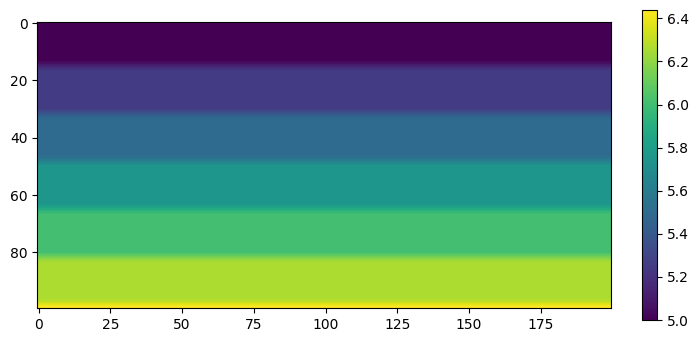

In [4]:
from scipy.interpolate import interp1d
def step_profile(x_range, y_range, step):
    y_step1 = np.round(np.arange(y_range[0], y_range[1]+step, step)/step) * step
    vp_step1 = y_step1/(y_range[1]-y_range[0]) * (6.5-5) + 5
    vs_step1 = y_step1/(y_range[1]-y_range[0]) * (4.48-3.46) + 3.46
    rho_step1 = y_step1/(y_range[1]-y_range[0]) * (3.32-2.72) + 2.72
    
    y_step2 = y_step1 + (y_step1[1] - y_step1[0] - step/5)
    vp_step2 = vp_step1
    vs_step2 = vs_step1
    rho_step2 = rho_step1

    idy = np.argsort(np.hstack([y_step1, y_step2]))
    y_step = np.hstack([y_step1, y_step2])[idy]
    vp_step = np.hstack([vp_step1, vp_step2])[idy]
    vs_step = np.hstack([vs_step1, vs_step2])[idy]
    rho_step = np.hstack([rho_step1, rho_step2])[idy]
    vp_step[-1:] = vp_step[-2]
    vs_step[-1:] = vs_step[-2]
    rho_step[-1:] = rho_step[-2]
    
    return y_step, vp_step, vs_step, rho_step

def build_layer_model(x, y, step):
    y_step, vp_step, vs_step, rho_step = step_profile([x[0], x[-1]], [y[0], y[-1]], step)

    vp = interp1d(y_step, vp_step, kind='slinear')(y)
    vs = interp1d(y_step, vs_step, kind='slinear')(y)
    rho = interp1d(y_step, rho_step, kind='slinear')(y)
    
    vp = np.tile(vp[np.newaxis,:], [len(x),1])
    vs = np.tile(vs[np.newaxis,:], [len(x),1])
    rho = np.tile(rho[np.newaxis,:], [len(x),1])
    
    model = {}
    model['vp'] = vp
    model['vs'] = vs
    model['rho'] = rho
    model['x'] = x
    model['y'] = y
    model['dx'] = x[1] - x[0]
    model['dy'] = y[1] - y[0]
    
    return model

x = np.arange(0,ny*dy/1000,dx/1000)
y = np.arange(0,nx*dx/1000,dy/1000)

step = 0.5 #km
model = build_layer_model(x, y, step)

plt.figure(figsize=(8,6))
plt.imshow(model['vp'].T)
plt.colorbar(fraction=0.025,pad = 0.05)
plt.show()


In [5]:
v = model['vp'].T * 1000
rho = np.power(v, 0.25) * 310

In [6]:
#######################################
#             子波设置
#######################################
#Source wavelet
f0 = 15 #Domain frequency
src = source_wavelet(nt, dt, f0, 'Ricker') #Ricker wavelet
st = integrate.cumtrapz(src, axis=-1, initial=0) #Integrate
tlist = np.arange(nt)*dt

#######################################
#              吸收边界设置
#######################################
#PML coefficient
vmax = 6500
damp_global = set_damp(vmax,nx_pml,ny_pml,pml,dx)

#######################################
#              炮和检波器设置
#######################################
# Source location
# src_x = np.array([nx-np.random.randint(5,12) for i in range(0,ny,25)]) + pml 
src_x = np.array([5 for i in range(10,ny-5,20)]) + pml 
src_y = np.array([i for i in range(10,ny-5,20)]) + pml
src_n = src_x.shape[0]

# free surface
mask =  (src_x==pml)
src_x[mask] = src_x[mask] + 1
#Receiver location
rcv_x = [5 for i in range(0,ny,5)]
rcv_y = [j+3 for j in range(0,ny,5)]
rcv_n = np.size(rcv_y)
rcv_x = np.array(rcv_x)
rcv_y = np.array(rcv_y)

In [7]:
#######################################
#              参数整理
#######################################
# modeling parameters
param = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
}
param = dictToObj(param)

# velocity model
vel_model ={
    "v":v,
    "rho":rho,
    "damp_global":damp_global
}
vel_model= dictToObj(vel_model)

# source
acoustic_src = {
    "src_x":src_x,
    "src_y":src_y,
    "src_n":src_n,
    "stf_val":st,
    "stf_t":tlist
}

acoustic_src = dictToObj(acoustic_src)

# receiver
acoustic_rcv = {
    'rcv_x':rcv_x,
    'rcv_y':rcv_y,
    'rcv_n':rcv_n
}
acoustic_rcv = dictToObj(acoustic_rcv)

In [8]:
import json 
param_save = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
}
model_save={
    "v":numpy2list(v),
    "rho":numpy2list(rho),
    "damp_global":numpy2list(damp_global),
    "src_x":numpy2list(src_x),
    "src_y":numpy2list(src_y),
    "src_n":src_n,
    "stf_val":numpy2list(st),
    "stf_t":numpy2list(tlist),
    'rcv_x':numpy2list(rcv_x),
    'rcv_y':numpy2list(rcv_y),
    'rcv_n':rcv_n
}
with open(os.path.join(save_path,"model/param_true.json"),'w') as f:
    json.dump(param_save,f)
with open(os.path.join(save_path,"model/model_true.json"),'w') as f:
    json.dump(model_save,f)


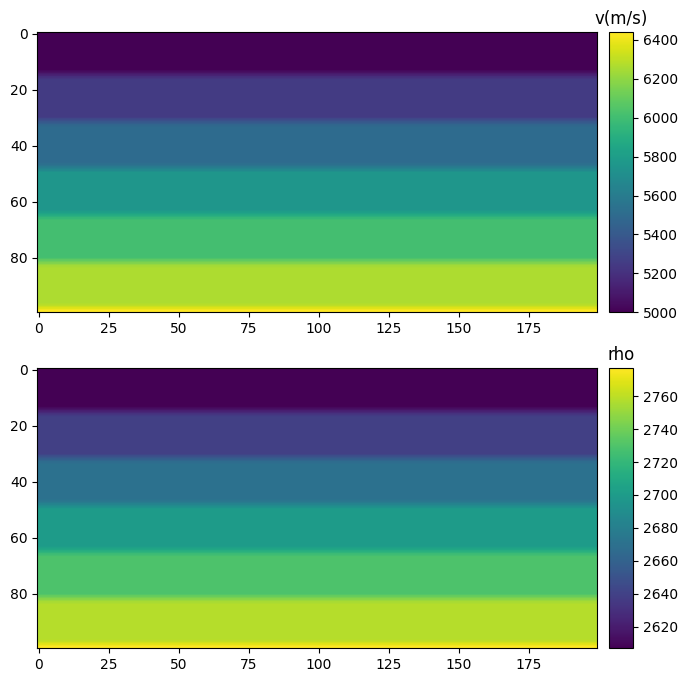

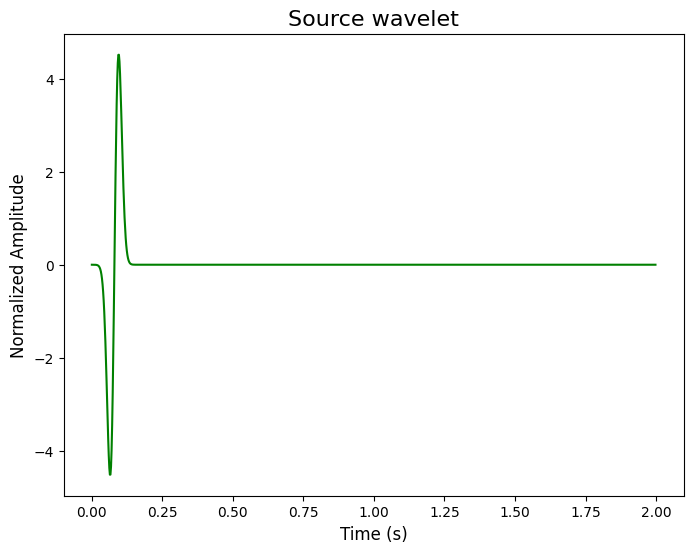

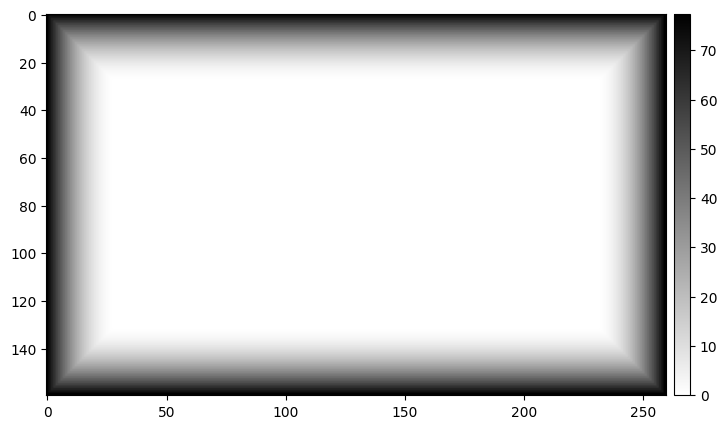

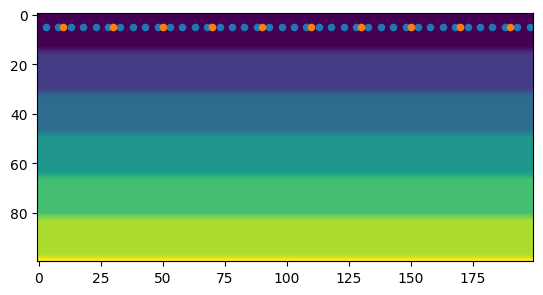

In [9]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/True/model.png"),show=True)
plot_wavelet(acoustic_src,save_path=os.path.join(save_path,"model/True/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/True/damp_global.png"),show=True)
plot_observeSystem(param,vel_model,acoustic_src,acoustic_rcv,save_path=os.path.join(save_path,"model/True/observed_system.png"),show=True)

In [10]:
#######################################
#         Forward simulation
#######################################
device = "cuda:0"
acoustic_sim = Acoustic_Simulation(param,vel_model,acoustic_src,acoustic_rcv,device=device)
# input model
rho = numpy2tensor(rho).to(device)
v = numpy2tensor(v).to(device)
csg = acoustic_sim.forward(v,rho)
# save the result
if device == 'cpu':
    csg = csg.detach().numpy()
else:
    csg = csg.cpu().detach().numpy()

np.savez(os.path.join(save_path,"obs/obs.npz"),obs_data = csg)

for i in range(src_n):
    # np.savetxt(os.path.join(save_path,"obs/s{}_obs.txt".format(i)),csg[i])
    wiggle(csg[i],np.arange(nt)*dt,save_path=os.path.join(save_path,"obs/figure/s{}_obs.png".format(i)))